# Numerical Differentiation for different dimensions

This iPython Notebook showcases how to compute derivatives of discrete signals, i.e. functions which are only known on a discrete set of points.

Since we don't have an analytical expression of the function we cannot use automatic differentiation (unless, we had fitted the function to a spline or something similar, but this is **not** the strategy taken in this project).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def diff(f, x):
    '''Returns three-point estimate (central difference) of derivative of f with respect to x'''
    df = np.diff(f)
    h = np.diff(x[:2])[0]
    dfdx_l = (-3*f[0] + 4*f[1] - f[2])/(2*h)
    dfdx_c = (df[1:] + df[:-1])/(2*h)
    dfdx_r = (f[-3] - 4*f[-2] + 3*f[-1])/(2*h)
    return np.hstack([dfdx_l, dfdx_c, dfdx_r])

## Examples

### $f : \mathbb{R} \to \mathbb{R}$

Consider:
$$
f(x) = \sin(a x) \\
f'(x) = a \cos(a x) \\
f''(x) = - a^2 \sin(ax)
$$

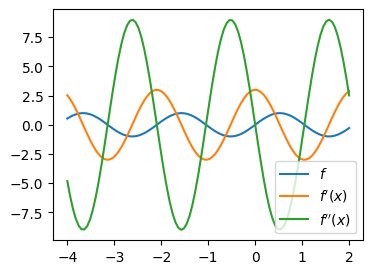

In [3]:
a = 3
x = np.linspace(-4, 2, 100)
f = np.sin(a*x)
_df = a*np.cos(a*x)
_ddf = -a**2 * np.sin(a*x)
plt.figure(figsize=(4,3))
plt.plot(x, f, label=r"$f$")
plt.plot(x, _df, label=r"$f'(x)$")
plt.plot(x, _ddf, label=r"$f''(x)$")
plt.legend()
plt.show()

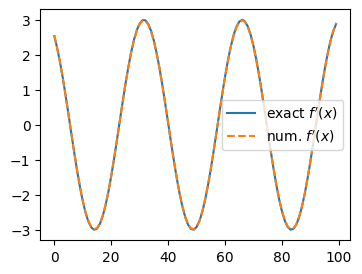

In [4]:
df = diff(f, x)
plt.figure(figsize=(4,3))
plt.plot(_df, label=r"exact $f'(x)$")
plt.plot(df, '--', label=r"num. $f'(x)$")
plt.legend()
plt.show()

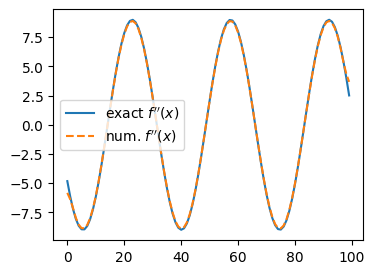

In [5]:
ddf = diff(diff(f, x),x)
plt.figure(figsize=(4,3))
plt.plot(_ddf, label=r"exact $f''(x)$")
plt.plot(ddf, '--', label=r"num. $f''(x)$")
plt.legend()
plt.show()

### $f : \mathbb{R}^2 \to \mathbb{R}$

Consider:
$$
f(x_1, x_2) = x_1 \sin(a x_2) \\[1em]

\partial_{x} f = 
\nabla f =
\left(
\begin{array}{c}
    \partial_{x_1} f \\
    \partial_{x_2} f
\end{array}
\right)
=
\left(
\begin{array}{c}
    \sin(a x_2) \\
    a x_1 \cos(a x_2)
\end{array}
\right)
$$

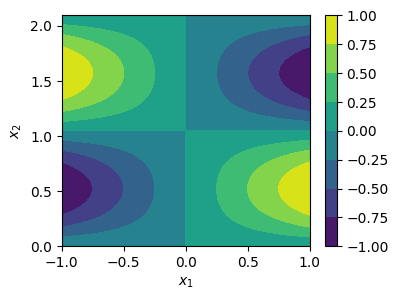

In [35]:
a=3
_f = lambda x1, x2 : x1 * np.sin(a*x2)
_df = lambda x1, x2 : np.stack((np.sin(a*x2),
                                 a * x1 * np.cos(a*x2)), axis=-1)

x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(0, 2/a*np.pi, 200)
X1, X2 = np.meshgrid(x1, x2, indexing='ij')
f = _f(X1, X2)

plt.figure(figsize=(4,3))
plt.contourf(X1, X2, f)
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

In [36]:
n1, n2 = f.shape
df = np.zeros((n1, n2, 2))
for i in range(n1):
    df[i, :, 1] = diff(f[i, :], x2)
for j in range(n2):
    df[:, j, 0] = diff(f[:, j], x1)

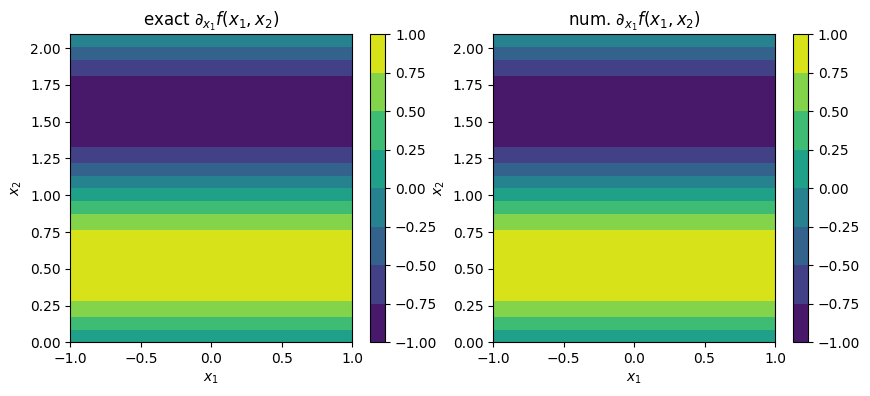

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
cont = ax[0].contourf(X1, X2, _df(X1, X2)[:, :, 0])
plt.colorbar(cont)
ax[0].set_xlabel(r'$x_1$')
ax[0].set_ylabel(r'$x_2$')
ax[0].set_title(r'exact $\partial_{x_1} f(x_1, x_2)$')

cont = ax[1].contourf(X1, X2, df[:, :, 0])
plt.colorbar(cont)
ax[1].set_xlabel(r'$x_1$')
ax[1].set_ylabel(r'$x_2$')
ax[1].set_title(r'num. $\partial_{x_1} f(x_1, x_2)$')

plt.show()

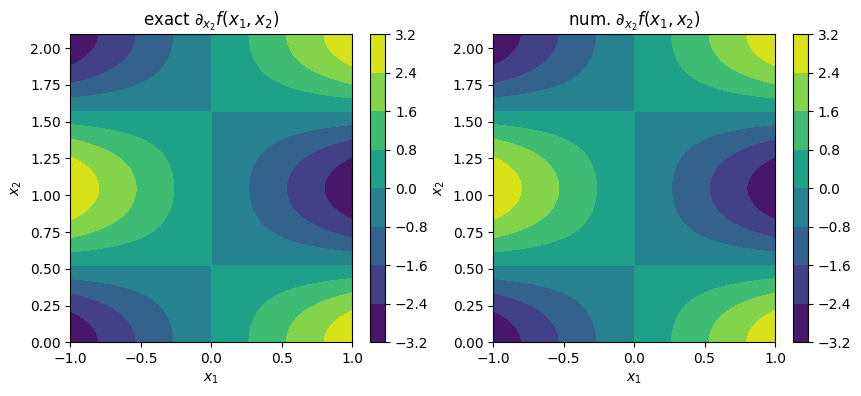

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
cont = ax[0].contourf(X1, X2, _df(X1, X2)[:, :, 1])
plt.colorbar(cont)
ax[0].set_xlabel(r'$x_1$')
ax[0].set_ylabel(r'$x_2$')
ax[0].set_title(r'exact $\partial_{x_2} f(x_1, x_2)$')

cont = ax[1].contourf(X1, X2, df[:, :, 1])
plt.colorbar(cont)
ax[1].set_xlabel(r'$x_1$')
ax[1].set_ylabel(r'$x_2$')
ax[1].set_title(r'num. $\partial_{x_2} f(x_1, x_2)$')

plt.show()

In [39]:
print('max abs. error: ', np.max(np.abs(_df(X1, X2) - df)))

max abs. error:  0.0009965567631744499


In [ ]:
# def grad(f, *args):
#     df = np.zeros((*f.shape, len(args)))
#     for i, xi in enumerate(args):
#         for j in range(f.shape[(i + 1) % len(args)]):
#             np.put_along_axis(df, j,
#                               values=diff(np.take(f, j, axis=i)),
#                               axis=i)